# Model explanation

Notebook to show characteristics of the fake news data and show how to build an accurate predictive model using tfidf and xgboost.

In [72]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle
import json

In [4]:
# read in data
df = pd.read_csv("fake_news/data/train.csv")

# concat title and body of article
df["all_text"] = (df.title + " " + df.text).values

# drop nulls
df = df[pd.notnull(df.all_text)]

print(f"non-null datapoints: {df.shape[0]}")

non-null datapoints: 20203


In [6]:
# split into train and test, 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(
    df["all_text"], df["label"], test_size=0.25, random_state=99
)

## Problem explanation

The dataset is split approximately 50:50 between fake and real news, in the training data 7821 articles are real news, 7331 are fake. This means that the dataset is well-balanced between classes.

An example of a naive classifier would therefore be to flip a coin. The matrix below shows how accurate we could expect to be on the test set if that was how we predicted fake news. The values are normalized to 100% in each row, ie. showing what proportion of each true lable has been accurately predicted. With the coin toss, we can see that about half are predicted accurately, as we'd expect.

The f1 score is similar to the proportion of fake news articles in the dataset.

In [12]:
y_train.value_counts()

0    7821
1    7331
Name: label, dtype: int64

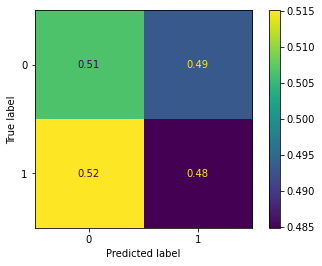

In [18]:
naive_preds = np.random.randint(2, size=y_test.shape[0])

ConfusionMatrixDisplay(confusion_matrix(y_test, naive_preds, normalize="true")).plot()

In [22]:
print(f"F1 score for naive predictor: {f1_score(y_test, naive_preds)}")

F1 score for naive predictor: 0.48627925746569817


## Tfidf

Stands for "Term-Frequency times Inverse Document-Frequency".

[Sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

This works by:

1. Find the top 10,000 most regular words in all of the text in the training set
2. Make a matrix where each column represents one of the 10k words and each row is an article, the values are the count of the appearances of the word in the article
3. Transform these counts to capture the frequency of the word in the article vs frequency in all of the articles together.

So we're taking a vector of text-strings and transforming it into a 10,000 column matrix of float representations.

In [7]:
vec = TfidfVectorizer(max_features=10000)

# fit_transform() fits the vectorizer and outputs a transformed matrix
X_train_float = vec.fit_transform(X_train)

# transform() uses the previously trained vectorizer
X_test_float = vec.transform(X_test)

In [9]:
print(f"untransformed text-string examples: {X_train.head()}\n")
print(f"transformed float-vector example: {X_train_float[0]}")

untransformed text-string examples: 11953    BREAKING: The FBI Has Ordered ALL Agents To Re...
7524     A combat veteran with PTSD wasn’t allowed to f...
9878     ’White Devils’: Muhammad Ali’s Racist Mosque S...
11151    Sweden Has Introduced a 6 Hour Working Day pos...
15076    WATCH: MILO and Martin Shkreli March on UC Dav...
Name: all_text, dtype: object

transformed float-vector example:   (0, 1868)	0.024041822310049157
  (0, 5167)	0.023624618615050007
  (0, 8294)	0.012303642666015614
  (0, 3954)	0.017218591790192708
  (0, 6689)	0.0277891258959877
  (0, 6379)	0.028003622508925977
  (0, 3416)	0.02346660492699375
  (0, 6305)	0.014209412106643685
  (0, 5259)	0.037269253750335816
  (0, 1638)	0.0400101766886417
  (0, 4178)	0.031088902994637655
  (0, 8506)	0.026432894493141745
  (0, 8906)	0.023620303586376217
  (0, 7963)	0.016455697037444636
  (0, 5563)	0.015383199934035465
  (0, 5088)	0.04322660742366176
  (0, 1926)	0.02872103831122076
  (0, 5361)	0.030522856829393905
  (0, 537)	0.0118

## Logistic Regression

Logistic regression is the most lightweight predictor we might use on this problem, but it performs very well using the transformed data, giving 96% accuracy.

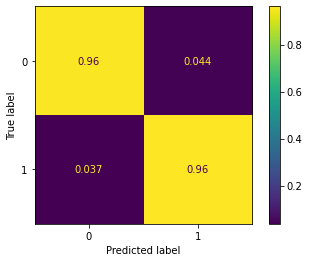

In [23]:
clf = LogisticRegression()
clf.fit(X_train_float, y_train)

lr_preds = clf.predict(X_test_float)

matrix = confusion_matrix(y_test, lr_preds, normalize="true")

ConfusionMatrixDisplay(matrix).plot()

In [24]:
print(f"F1 score for the logistic regression is: {f1_score(y_test, lr_preds)}")

F1 score for the logistic regression is: 0.9591182364729459


## Xgboost

Boosted trees are a bit more complex and generally get better results. Using xgboost we can up the accuracy to 97%. The `500` in the model training rows means 500 boost rounds, where a new model is trained to predict the errors of the previous iteration. This makes for quite a complex model.

Parameters are taken from `data explore` notebook.

In [35]:
parameters = {
    "max_depth": 8,
    "eta": 0.023417295129674713,
    "min_child_weight": 6,
    "gamma": 0.00616645159648425,
    "subsample": 0.8712535166224095,
    "colsample_bytree": 0.6120602654415218,
    "alpha": 0.00102362607551017,
    "lambda": 0.005267084500654618,
}

train_data = xgb.DMatrix(X_train_float, y_train)
test_data = xgb.DMatrix(X_test_float, y_test)

# training the model on trainset
bst = xgb.train(parameters, train_data, 500)

# predicting on unseen data
xgb_pred = bst.predict(test_data)>0.5

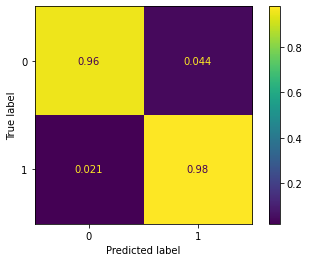

In [36]:
matrix = confusion_matrix(y_test, xgb_pred, normalize="true")

ConfusionMatrixDisplay(matrix).plot()

In [38]:
print(f"F1 score for the xgboost is: {f1_score(y_test, xgb_pred)}")

F1 score for the xgboost is: 0.9672033392963626


## Conclusion

I'd suggest sticking to the logistic regression model, it's much more lightweight and only slightly less accurate. 

## Scores

The model can output a percentage probability of fake news, so we could use that to traffic light each article.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

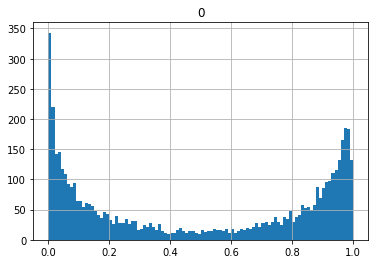

In [42]:
scores = clf.predict_proba(X_test_float)[:, 1]

pd.DataFrame(scores).hist(bins=100)

The chart shows the distribution of scores from 0 - 100%, they are distributed across the whole range with clusters at 0 and 1, a common pattern for logistic regression. 

In [57]:
train_scores = clf.predict_proba(X_train_float)[: , 1]

thirds = np.quantile(train_scores, [0.33, 0.66])
print(thirds)
thirds = [0] + list(thirds) + [1]

[0.12724488 0.83481253]


In [46]:
traffic_lights = pd.DataFrame(
    data={
        "actuals": y_test,
        "scores": scores
    }
)

In [52]:
traffic_lights["RAG"] = pd.cut(traffic_lights["scores"], thirds, labels=["Green", "Amber", "Red"])

In [56]:
pd.pivot_table(traffic_lights, index="RAG", values="actuals", aggfunc=["mean", "count"])

,mean,count
,actuals,actuals
RAG,,
Green,0.001265,1581
Amber,0.444695,1772
Red,0.998233,1698


The traffic lighting here is chosen to cut the data into approximate thirds. It has very accurate red and green categories (approx 0.1% errors in each case) but is possibly quite conservative. A better model would have as many articles as possible in red & green and fewer in amber. We might therefore set red, amber green to be a third of the range 0-1.

In [62]:
traffic_lights["RAG2"] = pd.cut(traffic_lights["scores"], [0,0.33,0.66,1], labels=["Green", "Amber", "Red"])
pd.pivot_table(traffic_lights, index="RAG2", values="actuals", aggfunc=["mean", "count"])

,mean,count
,actuals,actuals
RAG2,,
Green,0.009194,2284
Amber,0.475728,515
Red,0.985346,2252


This reduces the number of ambers significantly, without the number of errors growing hugely: 

* Green errors are 0.9%
* Red errors are 1 - 0.985 = 1.5%

We could be more aggressive still by only saying the middle 10% are amber, this is all a matter of preference.

In [63]:
traffic_lights["RAG3"] = pd.cut(traffic_lights["scores"], [0,0.45,0.55,1], labels=["Green", "Amber", "Red"])
pd.pivot_table(traffic_lights, index="RAG3", values="actuals", aggfunc=["mean", "count"])

,mean,count
,actuals,actuals
RAG3,,
Green,0.024155,2484
Amber,0.525180,139
Red,0.968699,2428


## Saving models

We need to save both the tfidf vectorizer and the trained logistic regression for future use.

In [82]:
logreg = {
    "coefs": list(clf.coef_[0]),
    "intercept": list(clf.intercept_)
}

with open("fake_news/models/logreg.json", "w") as f:
    json.dump(logreg, f)

In [83]:
with open("fake_news/models/logreg.pk", "wb") as f:
    pickle.dump(clf, f)

In [84]:
with open("fake_news/models/tfidf.pk", "wb") as f:
    pickle.dump(vec, f)

In [112]:
a = vec.transform([X_train[3]])
clf.predict_proba(a)[0, 1]

0.708754327229777

In [114]:
df.loc[3, "title"]

'15 Civilians Killed In Single US Airstrike Have Been Identified'